<a href="https://colab.research.google.com/github/believehan/AI_Study_Notes/blob/main/9_2_%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98%EB%A1%9C_%EC%88%9C%ED%99%98_%EC%8B%A0%EA%B2%BD%EB%A7%9D_%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

from keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [37]:
print(train_seq.shape, train_target.shape)

(20000, 100) (20000,)


In [38]:
train_seq = torch.tensor(train_seq)
val_seq = torch.tensor(val_seq)

In [39]:
print(train_target.dtype)

int64


In [40]:
train_target = torch.tensor(train_target, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)

In [41]:
print(train_target.dtype)

torch.float32


In [42]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_seq, train_target)
val_dataset = TensorDataset(val_seq, val_target)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [43]:
import torch.nn as nn

class IMDBRnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(500, 16)
        self.rnn = nn.RNN(16, 8, batch_first=True)
        self.dense = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.rnn(x)
        outputs = self.dense(hidden[-1])
        return self.sigmoid(outputs)

In [44]:
model = IMDBRnn()

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

IMDBRnn(
  (embedding): Embedding(500, 16)
  (rnn): RNN(16, 8, batch_first=True)
  (dense): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [45]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

In [47]:
train_hist = []
val_hist = []
patience = 2
best_loss = -1
early_stopping_counter = 0

epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    train_hist.append(train_loss)
    val_hist.append(val_loss)
    print(f"에포크:{epoch+1},훈련 손실:{train_loss:.4f}, 검증 손실{val_loss:.4f}")

    if best_loss == -1 or val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_rnn_model.pt')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"{epoch+1}번째 에포크에서 조기 종료됨")
            break

에포크:1,훈련 손실:0.6911, 검증 손실0.6906
에포크:2,훈련 손실:0.6891, 검증 손실0.6886
에포크:3,훈련 손실:0.6874, 검증 손실0.6869
에포크:4,훈련 손실:0.6853, 검증 손실0.6852
에포크:5,훈련 손실:0.6827, 검증 손실0.6821
에포크:6,훈련 손실:0.6787, 검증 손실0.6777
에포크:7,훈련 손실:0.6729, 검증 손실0.6714
에포크:8,훈련 손실:0.6657, 검증 손실0.6661
에포크:9,훈련 손실:0.6575, 검증 손실0.6595
에포크:10,훈련 손실:0.6497, 검증 손실0.6507
에포크:11,훈련 손실:0.6434, 검증 손실0.6450
에포크:12,훈련 손실:0.6367, 검증 손실0.6416
에포크:13,훈련 손실:0.6317, 검증 손실0.6386
에포크:14,훈련 손실:0.6278, 검증 손실0.6423
에포크:15,훈련 손실:0.6225, 검증 손실0.6309
에포크:16,훈련 손실:0.6184, 검증 손실0.6279
에포크:17,훈련 손실:0.6138, 검증 손실0.6268
에포크:18,훈련 손실:0.6098, 검증 손실0.6217
에포크:19,훈련 손실:0.6089, 검증 손실0.6210
에포크:20,훈련 손실:0.6035, 검증 손실0.6163
에포크:21,훈련 손실:0.6011, 검증 손실0.6148
에포크:22,훈련 손실:0.6063, 검증 손실0.6358
에포크:23,훈련 손실:0.6048, 검증 손실0.6146
에포크:24,훈련 손실:0.5950, 검증 손실0.6099
에포크:25,훈련 손실:0.5922, 검증 손실0.6070
에포크:26,훈련 손실:0.5878, 검증 손실0.6040
에포크:27,훈련 손실:0.5835, 검증 손실0.6047
에포크:28,훈련 손실:0.5808, 검증 손실0.6022
에포크:29,훈련 손실:0.5780, 검증 손실0.5990
에포크:30,훈련 손실:0.5763, 검증 손실0.5980
에포크:31,훈련 손실:0.5774

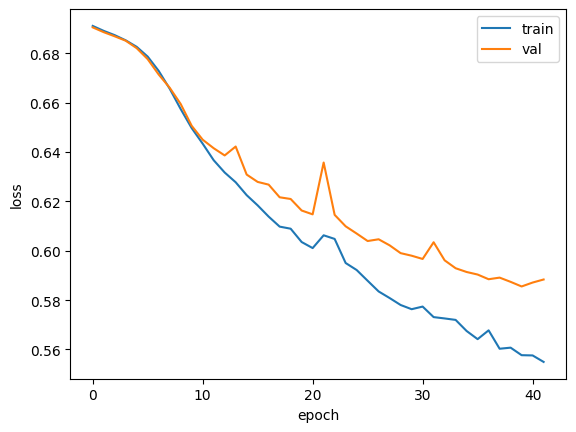

In [48]:
import matplotlib.pyplot as plt

plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [49]:
model.load_state_dict(torch.load('best_rnn_model.pt', weights_only=True))

model.eval()
corrects = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predicts = outputs > 0.5
        corrects += (predicts.squeeze() == targets).sum().item()

accuracy = corrects / len(val_dataset)
print(f"검증 정확도:{accuracy:.4f}")

검증 정확도:0.7026
